In [6]:
from pathlib import Path
import sys
import json
import PIL.Image
from random import choices

ROOT_DIR = Path().resolve().parent
sys.path.insert(0, str(ROOT_DIR))
from src import *

# Preview captions from renders (Objaverse)
[`generate_captions.py`](generate_captions.py) employs SOTA vision transformers (ViTs) to generate captions for the renders.
 
This notebook shows some samples.

The hyperparameters of the BLIP2 model that can be tweaked to improve the predictions are:

| Parameter        | Description                                                                                                                                               | Default |
| ---------------- | --------------------------------------------------------------------------------------------------------------------------------------------------------- | ------- |
| _Deterministic_|&nbsp;|
| `max_new_tokens` | Maximum number of tokens to generate beyond the prompt. Once this cap is reached, generation stops even without an end-of-sequence token.                 | `None`  |
| `num_beams`      | Number of beams for beam search. Higher values explore more candidate sequences (better quality but slower/more memory).                                  | `1`     |
| `length_penalty` | Exponent applied to sequence length during beam scoring. <1 favors longer outputs; >1 favors shorter ones.                                                | `1.0`   |
| `early_stopping` | If `True`, beam search stops when all beams hit end-of-sequence; if `False`, continues until `max_new_tokens` or best beam ends, rarely yielding a better overall score.                          | `False` |
|_Stochastic_|&nbsp;|
| `do_sample`      | If `True`, uses probabilistic sampling instead of deterministic (greedy or beam) decoding—introduces randomness for more varied outputs.                  | `False` |
| `temperature`    | Divides logits before softmax to adjust distribution sharpness. <1 makes choices more conservative; >1 makes them more random (only if `do_sample=True`). | `1.0`   |
| `top_p`          | Nucleus sampling threshold: keeps the smallest token set whose cumulative probability ≥ `top_p`, then samples from it. (Only if `do_sample=True`).        | `1.0`   |


In [ ]:
paths_render = sorted((ROOT_DIR / "dataset/objaverse/render").glob("*.jpg"))
paths_diffuse = sorted((ROOT_DIR / "dataset/objaverse/diffuse").glob("*.png"))
captions_t5 = json.load(open(ROOT_DIR / "dataset/objaverse/caption/captions_t5.json"))
captions_phi35 = json.load(open(ROOT_DIR / "dataset/objaverse/caption/captions_phi35.json"))

## BLIP2 Flan T5

A basic vision transformer with Google's T5.

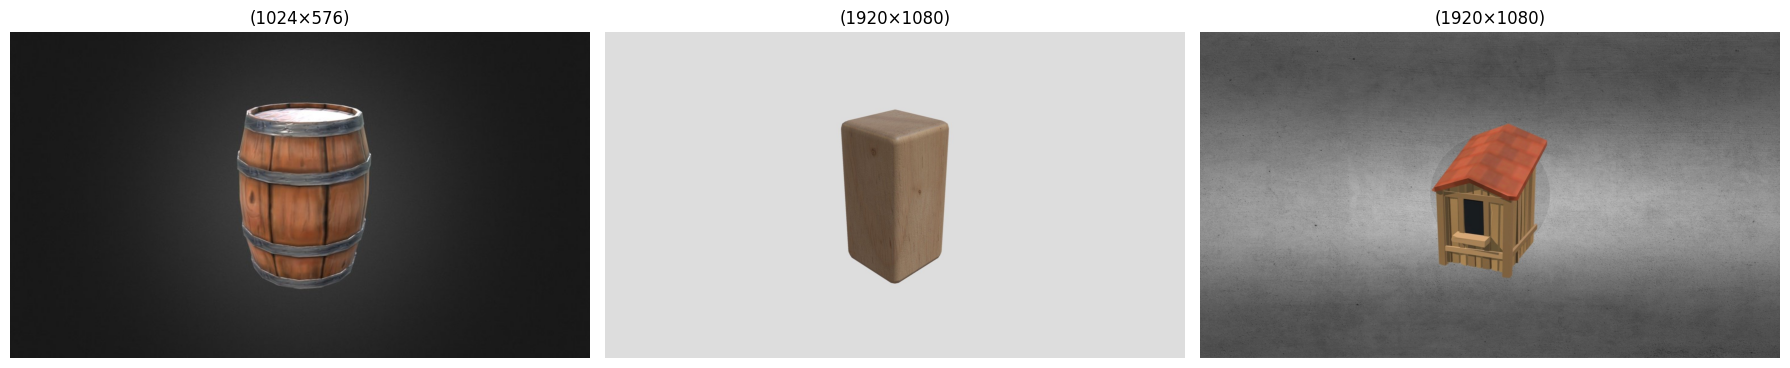

(['3d model of a wooden barrel',
  '3d model of a wooden cube',
  'a small wooden outhouse with a red roof'],
 'BLIP2 T5 -------- Phi 3.5',
 ['a wooden barrel with a metal band around its middle, showcasing a rich, warm brown color and a textured surface that suggests a rustic, aged appearance.',
  'a wooden cube with a natural, unfinished texture and a light brown color, showcasing the grain of the wood.',
  'a small wooden structure with a red tiled roof, featuring a dark entrance and a textured surface that suggests a weathered appearance.'])

In [ ]:
indexes = choices(range(len(captions_t5)), k=3)
selected_captions = [list(captions_t5.items())[x] for x in indexes]
plot_images(
    [PIL.Image.open(ROOT_DIR / "dataset/objaverse/render" / f"{uid}.jpg") for uid, _ in selected_captions],
    cols=3,
    size=6,
)
[v for _, v in selected_captions], "BLIP2 T5 -------- Phi 3.5", [captions_phi35[k] for k, _ in selected_captions]

### Renderings vs textures

Maybe should provide both the rendering and the texture?

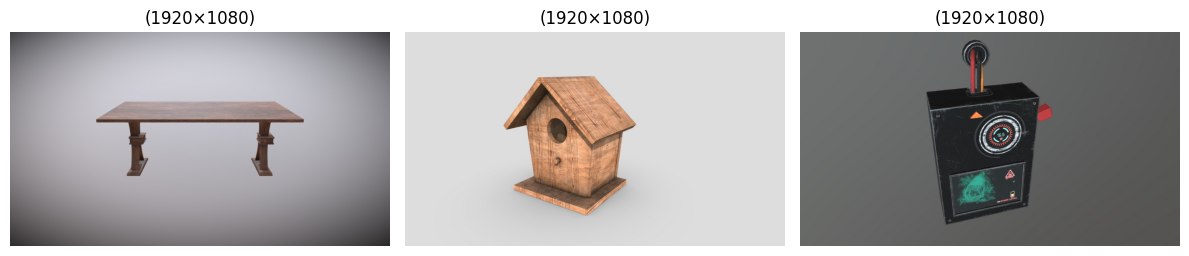

['the table is made of wood and metal',
 '3d model of a wooden birdhouse',
 '3d model of a futuristic alarm clock']

In [ ]:
selected_captions = [(x.stem, captions_t5[x.stem]) for x in paths_diffuse[:3]]
plot_images(
    [PIL.Image.open(ObjaverseDataset3D.DATASET_DIR / "render" / f"{uid}.jpg") for uid, _ in selected_captions],
    cols=3,
    size=4,
)
[x for _, x in selected_captions]

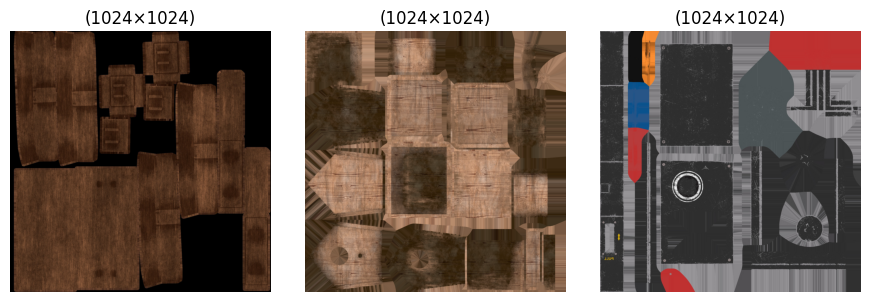

['the texture is a set of wood planks in a brown color',
 'The texture is made of wood and has a brown color',
 'the texture is made up of a mix of red, blue, and black']

In [10]:
plot_images([PIL.Image.open(x) for x in paths_diffuse[:3]], cols=3, size=3)
[
    "the texture is a set of wood planks in a brown color",
    "The texture is made of wood and has a brown color",
    "the texture is made up of a mix of red, blue, and black",
]

## Exploring other alternatives: Microsoft's Phi-3.5
Although being smaller, this one is way better.

For the second image in the previous sets (the bird house), we get these results:

| Model        | Caption  |
| ---------------- | ------------------------------------------------------------------ | 
| `BLIP2 Flan T5`|3d model of a wooden birdhouse. The texture is made of wood and has a brown color.|
| `Phi-3.5-vision-instruct`|A wooden birdhouse with a triangular roof and a rectangular base, featuring a single entrance hole and a small window. The wood has a natural, rustic texture and a warm, earthy color.|
|`mistral-medium-3-instruct`|This image depicts a quaint, small birdhouse with a classic triangular roof design, featuring an entrance hole on the front. The birdhouse appears to be constructed from light to medium brown wood, showcasing a natural grain texture. The surface has a slightly aged, rustic appearance, with a weathered, yet smooth|